In [1]:
import os
os.chdir('../../')

In [5]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import random

from main import parse_args_and_config, Diffusion
from datasets import inverse_data_transform

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.benchmark = False

###############################################################################
# 1) Notebook에서 sys.argv를 직접 설정 (argparse 흉내)
###############################################################################
sys.argv = [
    "main.py",
    "--config", "imagenet64.yml",  # 사용하려는 config
    "--sample",
    "--sample_type", "rbf_marginal",
    "--dpm_solver_type", "data_prediction",
    "--dpm_solver_order", "3",
    "--timesteps", "15",
    "--skip_type", "logSNR",
    "--log_scale_min", "-2.0",
    "--log_scale_max", "2.0",
    "--scale_dir", "/data/guided-diffusion/scale/rbf_ecp_marginal_M=128_64",
    "--ni"
]

###############################################################################
# 2) 인자/설정 로드
###############################################################################
args, config = parse_args_and_config()

###############################################################################
# 3) Diffusion 객체 생성 -> 모델 로딩
###############################################################################
diffusion = Diffusion(args, config, rank=0)
diffusion.prepare_model()
diffusion.model.eval()
print('done')

INFO - main.py - 2025-04-28 12:24:50,210 - Using device: cuda
INFO - main.py - 2025-04-28 12:24:50,210 - Using device: cuda


[prepare_model] Model is ready.
done


rbf_marginal
/data/guided-diffusion/scale/rbf_ecp_marginal_M=128_64/NFE=15,p=3,number=0.npz loaded!


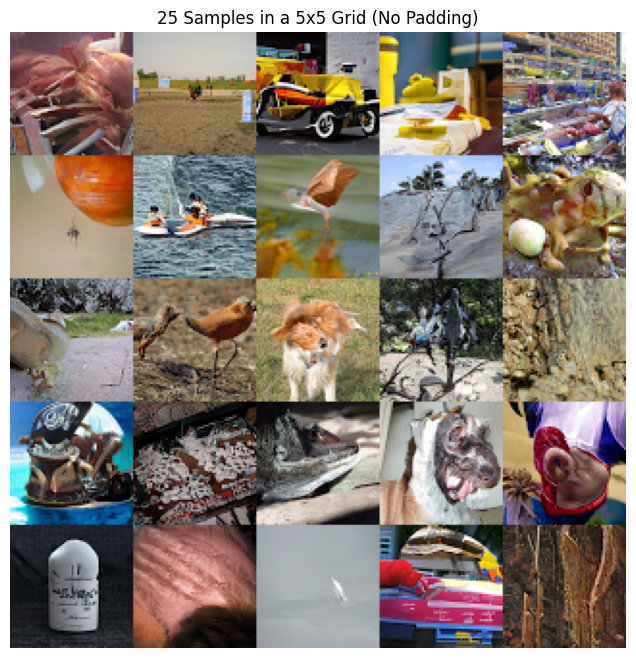

In [6]:

###############################################################################
# 4) 배치(25장) 한 번에 샘플링 -> 5x5 그리드(여백 없이) 시각화
###############################################################################
device = diffusion.device
num_samples = 25

# (a) 초기 노이즈 (배치 크기 25)
x = np.random.randn(num_samples, config.data.channels, config.data.image_size, config.data.image_size).astype(np.float32)
x = torch.tensor(x, device=device)

# (b) 모델로 샘플링 (배치 입력)
sampled_x, _ = diffusion.sample_image(x, diffusion.model)

# (c) [-1,1] → [0,1] 범위 변환
sampled_x = inverse_data_transform(config, sampled_x)

# (d) 5x5 그리드, padding=0 => 여백 없이
grid = vutils.make_grid(sampled_x, nrow=5, padding=0)

# (e) matplotlib 시각화
grid_np = grid.permute(1, 2, 0).cpu().numpy()
grid_np = np.clip(grid_np, 0, 1)

plt.figure(figsize=(8,8))
plt.imshow(grid_np)
plt.axis('off')
plt.title("25 Samples in a 5x5 Grid (No Padding)")
plt.show()


In [4]:
data = np.load('/data/guided-diffusion/scale/rbf_ecp_marginal_64/NFE=15,p=3.npz')
data['optimal_log_scales']

array([[-2.     ,  0.66875,  2.     ,  2.     ,  2.     ,  2.     ,
         2.     ,  2.     ,  2.     ,  2.     ,  2.     ,  2.     ,
         2.     ,  1.8    , -2.     ],
       [-1.4125 , -0.21875, -0.125  , -0.125  , -0.125  , -0.125  ,
        -0.125  , -0.125  , -0.13125, -0.125  , -0.125  , -0.0125 ,
        -0.025  , -0.0625 ,  0.     ]])